# Lab 06 Web Scraping

#### 1 What is web scraping?

Web scraping is the process of gathering data from websites and converting the unstructured data into structured data that can be stored and analyzed. Web scraping can be performed in several ways, depending on the complexity of the website and the data being targeted.

#### 2 Data formats

The data in websites can be presented in multiple formats such as HTML, Javascript, JSON, CSV, XML, images (like PNG), etc. Below, we introduce the scraping of JSON format data, and JavaScript in HTML, which are particularly prevalent in web development.

 - JavaScript is a powerful scripting language that enables interactive and dynamic content on web pages. In many cases, JavaScript is embedded directly within the HTML content of a website. This embedding is achieved through `<script>` tags that can either contain inline JavaScript code or link to external JavaScript files. JavaScript is often used to load content dynamically after the initial page load. This means that some data visible in a web browser might not be present in the HTML source fetched by simple HTTP request. 

- JSON is a handy way of exchanging data on the web, and with the right Python tools, you can easily fetch and work with this data. 

#### 3 Popular packages for web scraping 

 - `Requests`
Requests is a Python HTTP library designed to send all kinds of HTTP requests easily. It's the foundation for many web scraping tasks, allowing users to fetch web pages from the server.

 - `Beautiful Soup`
Beautiful Soup is a Python library for parsing HTML and XML documents. It creates parse trees that can be used to extract data easily.

- `Selenium`
Selenium is a tool for automating web browsers. It's primarily used for testing web applications but is also effective for scraping dynamic content. Selenium allows you to automate browser actions, such as clicking and scrolling, which can be necessary for interacting with JavaScript-heavy websites.


#### 4 Preparing for web scraping  
    
When preparing to scrape data from a website, it's important to understand how the website is structured and where the data you want to scrape is located. One effective way to do this is by investigating the website using the Developer Tools. 

- First, we open Developer Tools in Google Chrome by right-clicking anywhere on the page and select "Inspect" from the context menu. (Ctrl+Shift+I/Cmd+Opt+I). 

- Then we open the Network Tab. This tab shows all network requests made by the webpage. With the Network tab open, refresh the webpage to display all network requests made during the page. 
    
- Look through the list of requests in the Network tab to find requests fetching the data you're interested in.

#### 5 Handling Different Web Scraping Scenarios

Here, we introduce examples for dealing with three common web scraping scenarios: simple static content, multi-page navigation, and data presented in interactive maps.

1. Scraping Simple Static Content

- Many sites serve content directly in the HTML delivered upon the initial request, without requiring further client-side rendering or additional requests to display the full content.

- Method: Use libraries like `BeautifulSoup` or `lxml` in Python to parse the HTML and extract the needed information.

2. Scraping Multi-page Websites

- Many websites paginate their content across multiple pages to dynamically load content as the user navigates. Scraping such sites requires handling pagination or triggering the loading of additional content.

- Method: Identify the URL pattern for accessing subsequent pages (e.g., incrementing page numbers or tokens). Automate the process of adjusting the URL to fetch and parse content from each page.

3. Extracting Data from Interactive Maps

- Interactive maps often dynamically load data based on user interactions, such as zooming or panning. The data might be loaded via API calls returning JSON or other formats, which are then rendered on the map client-side.

- Method: Use the browser's Developer Tools to inspect network requests triggered by map interactions. Look for requests fetching geo-data and analyse their responses for structured data (e.g., GeoJSON).

`Not all the scraping is allowed by the website, especially for the commericial purposes. Always check the robots.txt file of the website before scraping.`

`In the UK, the UK copyright law allows us to do web scraping if this is for a non-commercial academic research purpose. Generally, we cannot share the scrapped data with anyone else and only use the data by ourselves. In rare cases, you may be able to share the scrapped data via existing data services, but that will require detailed legal investigation before you can do so.` 

In [2]:
# install the packages if you don't have them.
# !pip install requests
# !pip install beautifulsoup4
# !pip install pandas
# !pip install tqdm
# !pip install watermark
# ! pip install folium 

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import ast
from pandas import json_normalize
from tqdm import tqdm
import folium

In [3]:
%load_ext watermark
%watermark -p requests,pandas,matplotlib,tqdm,folium

requests  : 2.32.5
pandas    : 2.3.3
matplotlib: 3.10.8
tqdm      : 4.67.1
folium    : 0.20.0



## 1. The Basics – HTML Parsing with BeautifulSoup

- Scrap the information of from quotes to scrape.
- Website: http://quotes.toscrape.com/
- The data is included directly in the HTML tags. 

In [ ]:
# Define the URL
# quotes.toscrape.com is a sandbox site made for practicing scraping
url = "http://quotes.toscrape.com/"

# Get the HTML
# We verify status_code is 200 (OK) to ensure the site is reachable
response = requests.get(url)

if response.status_code == 200:
    print("Successfully connected to the website!")
    
    # Parse the HTML
    # 'html.parser' creates a tree structure we can search through
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find Elements
    # We look for all <div> tags that have the class "quote"
    quote_elements = soup.find_all('div', class_='quote')

    scraped_data = []

    # Loop through results and extract specific text
    for card in quote_elements:
        # Find the quote text (inside a <span> with class 'text')
        text = card.find('span', class_='text').text
        
        # Find the author (inside a <small> tag with class 'author')
        author = card.find('small', class_='author').text
        
        # Store in a dictionary
        scraped_data.append({
            'author': author, 
            'quote': text
        })

    # Convert to DataFrame for easy viewing
    df = pd.DataFrame(scraped_data)
    display(df.head(10))

else:
    print(f"Failed to connect. Status code: {response.status_code}")

Successfully connected to the website!


,author,quote
0,Albert Einstein,“The world as we have created it is a process ...
1,J.K. Rowling,"“It is our choices, Harry, that show what we t..."
2,Albert Einstein,“There are only two ways to live your life. On...
3,Jane Austen,"“The person, be it gentleman or lady, who has ..."
4,Marilyn Monroe,"“Imperfection is beauty, madness is genius and..."
5,Albert Einstein,“Try not to become a man of success. Rather be...
6,André Gide,“It is better to be hated for what you are tha...
7,Thomas A. Edison,"“I have not failed. I've just found 10,000 way..."
8,Eleanor Roosevelt,“A woman is like a tea bag; you never know how...
9,Steve Martin,"“A day without sunshine is like, you know, nig..."


## 2. General scraping of html content on a website (Parsing embedded Javascript)

- Scrap the information of property to rent from Openrent website. 
- Website: https://www.openrent.co.uk/properties-to-rent/
- This is a slightly more complicated scraping task since the data is embedded in the Javascript. 

We start by manually identifying the URL link address through the inspection of the Network tab within the website's development tools. 

Once the target URL is identified, we send an HTTP GET request to this URL with `requests` library.


In [5]:
response = requests.get('https://www.openrent.co.uk/properties-to-rent/glasgow') # Sends an HTTP GET request to the target URL
response.raise_for_status() # Checks the status code of the HTTP response

# If the HTTP request was successful (i.e., the status code is in the 200–299 range), no exception information will be returned. 
# If the server returns an error code (i.e., the status code is 400 or above), raise_for_status() will raise an HTTPError.


Now, we have HTML content loaded into a variable named `html_content`. This content is a string containing the full HTML of the page. 

Then use `BeautifulSoup` library for parsing HTML or XML documents. It can create a parse tree from page source code that can be used to extract data easily.

In [6]:
html_content = response.text #  get the body of the response, i.e., the HTML content of the page, as a string
soup = BeautifulSoup(html_content, 'html.parser') # parsing HTML content

Then use the `.find_all()` method on the BeautifulSoup object `soup` to locate all `<script>` tags within the HTML content. Among all the `<script>` tags found, we are just interested in one specific tag. We can find the location of the specific  `<script>` tag `47` by by inspecting the webpage's source code.

In [7]:
def find_target_script(soup):
    scripts = soup.find_all('script')
    for script in scripts:
        if script.string and 'var prices =' in script.string:
            return script.string
    return None

In [8]:
target_script_content = find_target_script(soup)

In [9]:
target_script_content

'\r\n\r\n    // Initialise Variables for search js\r\n    var searchByLandlord = false;\r\n    //save default term, area\r\n    var defaultTerm = "Glasgow".replace(/&#39;/g, "\'"); // decode apostrophes\r\n    var defaultArea = "8";\r\n\r\n    var islivelistBool = [\r\n1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,    ];\r\n\r\n    var prices = [\r\n1300,1050,

The final step is to tidy up the data and ensure it is clean and well-structured.

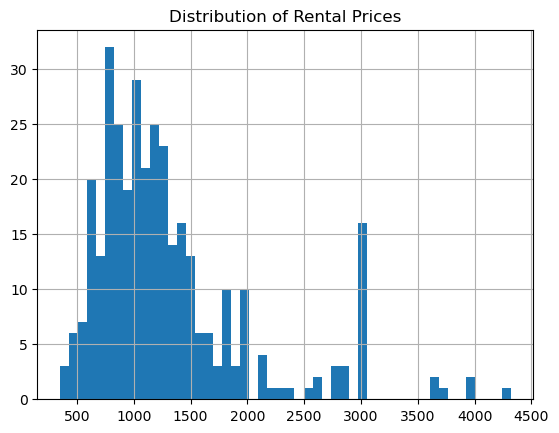

In [10]:
# A function to extract the JavaScript arrays as strings and then convert them into Python lists. 
def extract_js_array(target_script_content, variable_name):
    # Find the target array
    pattern = re.compile(r"var\s+" + re.escape(variable_name) + r"\s*=\s*(\[[^\]]*\]);", re.DOTALL)
    match = pattern.search(target_script_content)
    if match:
        array_str = match.group(1)
        array_data = ast.literal_eval(array_str)
        return array_data
    else:
        print(f"{variable_name} not found")
    return None

# Apply this function to your target variables (e.g., prices, bedrooms, latitudes, longitudes etc.) to extract different information related to housing.
variables = [
    'prices', 'bedrooms', 'bathrooms', 'students', 'nonStudents',
    'dss', 'pets', 'isstudio', 'isshared', 'furnished', 'hasVideo',
    'propertyTypes', 'hoursLive', 'gardens', 'parkings', 'bills',
    'availableFrom', 'minimumTenancy', 'PROPERTYIDS', 'PROPERTYLISTLATITUDES',
    'PROPERTYLISTLONGITUDES'
]

data = {}
for var in variables:
    data[var] = extract_js_array(target_script_content, var)

# Organize it into a pandas DataFrame. 
property_info = pd.DataFrame(data) 

property_info.head()

import matplotlib.pyplot as plt
property_info['prices'].hist(bins=50)
plt.title("Distribution of Rental Prices")
plt.show()

## 3. Scrape maps (API scraping)

- Scrap fueling stations from the map ojects in a wesite.
- Website: https://www.fuelgenie.co.uk/fuel-cards-uk-locations/find-nearest-petrol-station/

In [11]:
# The information of the map is stored in JSON format on the website.
response = requests.get('https://www.fuelgenie.co.uk/umbraco/api/stationsapi/getallstations')
response.raise_for_status()

In [12]:
# Parse the JSON response to a Python dictionary.
data = response.json()
df = json_normalize(data)

df.head()

,id,mid,siteName,cardType,companyCode,companyName,openingTimes,facilitiesList,fuelPricesList,distance,address.addressLine1,address.addressLine2,address.addressLine3,address.addressLine4,address.addressLine5,address.postCode,latLong.latitude,latLong.longitude
0,25403735,25403735,Tesco Elmers End,1,TES,Tesco Stores Ltd,"[{'day': 'Monday', 'isOpen': True, 'openingTim...","[{'facilityName': 'Car Wash', 'facilityAvailab...","[{'fuelTypeName': 'Diesel', 'fuelPrice': {'cur...",0,Croydon Road,,,Beckenham,Outer London,BR3 4AA,51.397100,-0.048735
1,25403832,25403832,Tesco Stoke,1,TES,Tesco Stores Ltd,"[{'day': 'Monday', 'isOpen': True, 'openingTim...","[{'facilityName': 'Car Wash', 'facilityAvailab...","[{'fuelTypeName': 'Diesel', 'fuelPrice': {'cur...",0,291 Newcastle Road,Springfields,,Newcastle-Under-Lyme,Stoke-On-Trent,ST4 6PL,52.994408,-2.209191
2,25811746,25811746,Sainsburys Archer Road,1,SAI,Sainsburys Supermarkets Ltd,"[{'day': 'Monday', 'isOpen': True, 'openingTim...","[{'facilityName': 'Car Wash', 'facilityAvailab...","[{'fuelTypeName': 'Diesel', 'fuelPrice': {'cur...",0,Archer Road,Millhouses,,Sheffield,South Yorkshire,S8 0TD,53.345079,-1.491356
3,25821324,25821324,Sainsburys Thanet,1,SAI,Sainsburys Supermarkets Ltd,"[{'day': 'Monday', 'isOpen': True, 'openingTim...","[{'facilityName': 'Car Wash', 'facilityAvailab...","[{'fuelTypeName': 'Diesel', 'fuelPrice': {'cur...",0,Dadson Way,,,Ramsgate,Kent,CT12 5FJ,51.356031,1.393844
4,25402594,25402594,Great Wyrley Express,1,TES,Tesco Stores Ltd,"[{'day': 'Monday', 'isOpen': True, 'openingTim...","[{'facilityName': 'Car Wash', 'facilityAvailab...","[{'fuelTypeName': 'Diesel', 'fuelPrice': {'cur...",0,Walsall Road,Great Wyrley,,Walsall,Staffordshire,WS6 6LA,52.666863,-2.016179


## 4. Scrape multi-page website (API scraping)
- Scrap the names, locations, opening hours of Sainsbury's in London.
- Website: https://stores.sainsburys.co.uk/list/place/@51.50643,-0.12719/1/all

In [13]:
response = requests.get('https://stores.sainsburys.co.uk/api/v1/stores/?fields=slfe-list-2.21&api_client_id=slfe&lat=51.50643&lon=-0.12719&limit=25&store_type=main%2Clocal&sort=by_distance&within=15&page=1')
response.raise_for_status()

In [14]:
data = response.json()
df = json_normalize(data['results'])
df.head()

,closed,code,district_code,exception_times,name,opening_times,opening_times_message,originator_id,other_name,store_type,...,open.today.start_time,open.today.times,open.tomorrow.24hrs,open.tomorrow.end_time,open.tomorrow.exception,open.tomorrow.start_time,open.tomorrow.times,closed.description,closed.end_date,closed.start_date
0,NaN,4286,4286,"[{'date': '2025-12-24', 'description': 'Christ...",Wsmtr The Strand Loc,"[{'day': 0, 'end_time': '23:00', 'start_time':...",None,None,Westminster The Strand Local,local,...,07:00,"[{'end_time': '23:00', 'start_time': '07:00'}]",False,23:00,False,07:00,"[{'end_time': '23:00', 'start_time': '07:00'}]",NaN,NaN,NaN
1,NaN,5069,5069,"[{'date': '2025-12-24', 'description': 'Christ...",Leicester Square Loc,"[{'day': 0, 'end_time': '23:59', 'start_time':...",None,None,Leicester Square Local,local,...,07:00,"[{'end_time': '23:59', 'start_time': '07:00'}]",False,23:59,False,07:00,"[{'end_time': '23:59', 'start_time': '07:00'}]",Closed for store investment,2026-01-30,2026-01-29
2,NaN,5127,5127,"[{'date': '2025-12-24', 'description': 'Christ...",Waterloo Station Loc,"[{'day': 0, 'end_time': '00:00', 'start_time':...",None,None,Waterloo Station Local 5127,local,...,06:00,"[{'end_time': '00:00', 'start_time': '06:00'}]",False,00:00,False,06:00,"[{'end_time': '00:00', 'start_time': '06:00'}]",NaN,NaN,NaN
3,NaN,4073,4073,"[{'date': '2025-12-24', 'description': 'Christ...",Waterloo LL,"[{'day': 0, 'end_time': '23:59', 'start_time':...",None,None,Waterloo Local,local,...,00:00,"[{'end_time': '23:59', 'start_time': '00:00'}]",True,23:59,False,00:00,"[{'end_time': '23:59', 'start_time': '00:00'}]",NaN,NaN,NaN
4,NaN,5062,5062,"[{'date': '2025-12-24', 'description': 'Christ...",Myfr Stratton St Loc,"[{'day': 0, 'end_time': '23:00', 'start_time':...",None,None,Mayfair Stratton Street Local,local,...,06:30,"[{'end_time': '23:00', 'start_time': '06:30'}]",False,23:00,False,06:30,"[{'end_time': '23:00', 'start_time': '06:30'}]",NaN,NaN,NaN


The method described above only retrieves information from the first page. To get the information of all the stores in London, we need to access data from all available pages.

When manually changing pages, we can find that the only difference is the page number at the end of the URL. For many websites, the total page number is known, therefore, multi-page scraping can be easily achieved by setting up a loop to iterate over all page URLs. 

However, this approach is not applicable to all the websites. In many cases, the total pages in hidden by the website. A more general way to scrap multi-page webiste is described below. 

In [15]:
multi_page_df = pd.DataFrame()

# Base URL for the API request, without the page number
base_url = 'https://stores.sainsburys.co.uk/api/v1/stores/?fields=slfe-list-2.21&api_client_id=slfe&lat=51.50643&lon=-0.12719&limit=25&store_type=main%2Clocal&sort=by_distance&within=15&page='
current_page = 1

while True:
    # Construct the full URL for the current page
    url = f"{base_url}{current_page}"

    response = requests.get(url)
    response.raise_for_status()  
    data = response.json()  #
    
    page_meta = data['page_meta']

    # Check if the sum of limit and offset is less than total, which indicates more pages
    if page_meta['limit']  + page_meta['offset'] < page_meta['total']:
        df = json_normalize(data['results'])
        multi_page_df = pd.concat([multi_page_df, df], ignore_index=True)

        # Prepare to fetch the next page
        current_page +=1

    else:
        df = json_normalize(data['results'])
        multi_page_df = pd.concat([multi_page_df, df], ignore_index=True)
        
         # Break out of the loop since we've reached the last page
        break


print(len(multi_page_df))
multi_page_df.head()

413


,closed,code,district_code,exception_times,name,opening_times,opening_times_message,originator_id,other_name,store_type,...,open.today.start_time,open.today.times,open.tomorrow.24hrs,open.tomorrow.end_time,open.tomorrow.exception,open.tomorrow.start_time,open.tomorrow.times,closed.description,closed.end_date,closed.start_date
0,NaN,4286,4286,"[{'date': '2025-12-24', 'description': 'Christ...",Wsmtr The Strand Loc,"[{'day': 0, 'end_time': '23:00', 'start_time':...",None,None,Westminster The Strand Local,local,...,07:00,"[{'end_time': '23:00', 'start_time': '07:00'}]",False,23:00,False,07:00,"[{'end_time': '23:00', 'start_time': '07:00'}]",NaN,NaN,NaN
1,NaN,5069,5069,"[{'date': '2025-12-24', 'description': 'Christ...",Leicester Square Loc,"[{'day': 0, 'end_time': '23:59', 'start_time':...",None,None,Leicester Square Local,local,...,07:00,"[{'end_time': '23:59', 'start_time': '07:00'}]",False,23:59,False,07:00,"[{'end_time': '23:59', 'start_time': '07:00'}]",Closed for store investment,2026-01-30,2026-01-29
2,NaN,5127,5127,"[{'date': '2025-12-24', 'description': 'Christ...",Waterloo Station Loc,"[{'day': 0, 'end_time': '00:00', 'start_time':...",None,None,Waterloo Station Local 5127,local,...,06:00,"[{'end_time': '00:00', 'start_time': '06:00'}]",False,00:00,False,06:00,"[{'end_time': '00:00', 'start_time': '06:00'}]",NaN,NaN,NaN
3,NaN,4073,4073,"[{'date': '2025-12-24', 'description': 'Christ...",Waterloo LL,"[{'day': 0, 'end_time': '23:59', 'start_time':...",None,None,Waterloo Local,local,...,00:00,"[{'end_time': '23:59', 'start_time': '00:00'}]",True,23:59,False,00:00,"[{'end_time': '23:59', 'start_time': '00:00'}]",NaN,NaN,NaN
4,NaN,5062,5062,"[{'date': '2025-12-24', 'description': 'Christ...",Myfr Stratton St Loc,"[{'day': 0, 'end_time': '23:00', 'start_time':...",None,None,Mayfair Stratton Street Local,local,...,06:30,"[{'end_time': '23:00', 'start_time': '06:30'}]",False,23:00,False,06:30,"[{'end_time': '23:00', 'start_time': '06:30'}]",NaN,NaN,NaN


In [16]:
# visualise all the stores we scrapped on a map 

# Define a function to determine the color based on the store type
def determine_color(store_type):
    if store_type == 'local':
        return 'orange'
    elif store_type == 'main':
        return 'green'

m = folium.Map(location=[55, -2], zoom_start=6)

# Iterate over the DataFrame rows, add each as a point on the map with dynamic color and popup
for index, row in multi_page_df.iterrows():
    color = determine_color(row['store_type'])
    popup_text = f"Name: {row['other_name']}"
    folium.CircleMarker(
        location=[row['location.lat'], row['location.lon']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=1,
        popup=folium.Popup(popup_text, parse_html=True)
    ).add_to(m)

# Display the map
m